Problem mit den price_per_mile also Verhältnis von total miles und total price
Verhältnis und dann alle Ausreiser rausschmeißen (Randfälle sind bei 100 000 schon 15 000, also keine gute Lösung?!?!)
Möglichkeit Distanz und Zeit künstlich hinzufügen durch (Durchschnitt, Distanzberechnung, oder gleicher Start und Endort)

Weitere Features für das Clustering durch POI und Census Tract data und evtl Sports Data (Erst Distanzmessung, dann Boolean durch Join an POI Data, zum Beispiel Fahrt zum Sportevent oder Fahrt zum Cafe etc...

Distance to city centre (welche Norm?) oder gar andere API, die uns genau Fahrtzeit angibt

Welche spatial Information? Census-Tract Koordinaten, Community Area Daten, Centroid Daten und H3 mit Res 4, 6, 8

Feature Engineering (Booleans und Distances)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from matplotlib.ticker import MultipleLocator

In [2]:
data = pd.read_csv("../data/analytics_trip_data.csv", nrows = 100000)

In [3]:
pd.set_option('display.max_colwidth', None)
# Korrekte Verwendung der describe-Methode
data.describe()

# Überprüfe auf NaN-Werte jeder Spalte
nan_info = data.isna().sum()
print(nan_info)

trip_id                          0
taxi_id                          0
trip_start_timestamp             0
trip_end_timestamp               0
trip_seconds                     0
trip_miles                       0
pickup_census_tract          23121
dropoff_census_tract         23121
pickup_community_area            0
dropoff_community_area           8
fare                             0
tips                             0
tolls                            0
extras                           0
trip_total                       0
payment_type                     0
company                          0
pickup_centroid_location         0
dropoff_centroid_location        0
h3_res_4                         0
h3_res_6                         0
h3_res_8                         0
h3_res_4_dropoff                 0
h3_res_6_dropoff                 0
h3_res_8_dropoff                 0
date                             0
temperature                      0
precipitation                    0
dtype: int64


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trip_id                    100000 non-null  object 
 1   taxi_id                    100000 non-null  object 
 2   trip_start_timestamp       100000 non-null  object 
 3   trip_end_timestamp         100000 non-null  object 
 4   trip_seconds               100000 non-null  float64
 5   trip_miles                 100000 non-null  float64
 6   pickup_census_tract        76879 non-null   float64
 7   dropoff_census_tract       76879 non-null   float64
 8   pickup_community_area      100000 non-null  float64
 9   dropoff_community_area     99992 non-null   float64
 10  fare                       100000 non-null  float64
 11  tips                       100000 non-null  float64
 12  tolls                      100000 non-null  float64
 13  extras                     100

1. Further Data Preparation and Cleaning

In [5]:
data.head(1)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,dropoff_centroid_location,h3_res_4,h3_res_6,h3_res_8,h3_res_4_dropoff,h3_res_6_dropoff,h3_res_8_dropoff,date,temperature,precipitation
0,0a0a2ca50df85134ce34f0c2c7bda6e78ca2a52c,bbe793119144e0bd97a4268af2a28ed0f3dad49545592ca9bc849b861760fd298cc9d873f749e3d8bad467cd77174ec6c05efa2b72af529b68ae7d01ff4c3fec,2018-01-01 00:15:00,2018-01-01 00:15:00,180.0,0.0,1.703108e+10,1.703132e+10,8.0,32.0,...,POINT (-87.6209929134 41.8849871918),862664c1fffffff,842664dffffffff,882664c1e1fffff,842664dffffffff,862664c1fffffff,882664c1e3fffff,2018-01-01 01:53:00,-18.333333,0.0


In [6]:
#Hier erstmal date genommen, vielleicht doch lieber startzeit?
data['date_column'] = pd.to_datetime(data['date'])
data['hour']= data["date_column"].dt.hour
data['weekday']=data["date_column"].dt.weekday
data["month"]=data["date_column"].dt.month
data['price_per_mile'] = data.apply(lambda row: row['trip_total'] / row['trip_miles'] if row['trip_miles'] != 0 and row['trip_total'] != 0 else np.nan, axis=1)

In [7]:
#features = ["trip_id", "taxi_id", "trip_start_timestamp", "trip_end_timestamp", "trip_seconds", "trip_miles", "pickup_census_tract", "dropoff_census_tract", "pickup_community_area", "dropoff_community_area", "fare", "tips", "tolls", "extras", "trip_total", "payment_type", "company", "pickup_centroid_latitude", "pickup_centroid_longitude", "pickup_centroid_location", "dropoff_centroid_latitude", "dropoff_centroid_longitude", "dropoff_centroid_location"]
features = ["trip_seconds", "trip_miles","fare", "tips", "tolls", "extras", "trip_total", "hour", "weekday", "month","precipitation","temperature","price_per_mile"]

Brauchen wir eine Unterscheidung zwischen den Trips?????? So wie bei dem letzten Projekt bei Site1 und Site2??

In [8]:
Cluster_all = data[features]

In [9]:
Cluster_all.info()
print(len(Cluster_all))
print(Cluster_all['price_per_mile'].isna().sum())
Cluster_all.dropna(inplace=True)
print(len(Cluster_all))
Cluster_all.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   trip_seconds    100000 non-null  float64
 1   trip_miles      100000 non-null  float64
 2   fare            100000 non-null  float64
 3   tips            100000 non-null  float64
 4   tolls           100000 non-null  float64
 5   extras          100000 non-null  float64
 6   trip_total      100000 non-null  float64
 7   hour            100000 non-null  int32  
 8   weekday         100000 non-null  int32  
 9   month           100000 non-null  int32  
 10  precipitation   100000 non-null  float64
 11  temperature     100000 non-null  float64
 12  price_per_mile  85515 non-null   float64
dtypes: float64(10), int32(3)
memory usage: 8.8 MB
100000
14485
85515


C:\Users\kevin\AppData\Local\Temp\ipykernel_19732\8445324.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cluster_all.dropna(inplace=True)


,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,hour,weekday,month,precipitation,temperature,price_per_mile
count,85515.000000,85515.000000,85515.000000,85515.000000,85515.0,85515.000000,85515.000000,85515.000000,85515.000000,85515.0,85515.0,85515.000000,85515.000000
mean,483.930737,1.491054,7.741230,0.856260,0.0,0.305276,9.049110,12.453909,1.757540,1.0,0.0,-14.299558,10.804915
std,261.142816,1.166052,3.010742,1.175554,0.0,0.560102,3.505755,5.743729,1.130321,0.0,0.0,4.116229,19.781217
min,0.000000,0.010000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.0,0.0,-22.777778,0.292105
25%,300.000000,0.700000,5.500000,0.000000,0.0,0.000000,6.500000,8.000000,1.000000,1.0,0.0,-17.222222,5.138889
50%,420.000000,1.100000,7.000000,0.000000,0.0,0.000000,8.250000,13.000000,2.000000,1.0,0.0,-14.444444,6.923077
75%,620.000000,1.860000,9.000000,2.000000,0.0,0.500000,10.750000,17.000000,3.000000,1.0,0.0,-10.555556,9.500000
max,1500.000000,5.850000,20.500000,5.000000,0.0,2.500000,24.000000,23.000000,4.000000,1.0,0.0,-7.777778,950.000000


In [10]:
Cluster_all_ohe = pd.get_dummies(Cluster_all, columns=["hour", "weekday", "month"])

In [11]:
Cluster_all_ohe.head(1)

,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,precipitation,temperature,price_per_mile,...,hour_20,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,month_1
1,217.0,0.61,4.75,0.0,0.0,1.5,6.25,0.0,-18.333333,10.245902,...,False,False,False,False,True,False,False,False,False,True


In [12]:
print(Cluster_all_ohe.columns)

Index(['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'precipitation', 'temperature', 'price_per_mile',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'month_1'],
      dtype='object')


In [13]:
columns_to_normalize=["trip_seconds", "trip_miles","fare", "tips", "tolls", "extras", "trip_total", "precipitation", "temperature","price_per_mile"]
#columns_to_normalize=['connectionDuration', 'chargingDuration', 'kWhDelivered', 'kWhRequested', 'precipitation', 'temperature', 'minutesAvailable']

In [14]:
scaler = MinMaxScaler()
Cluster_all_ohe[columns_to_normalize] = scaler.fit_transform(Cluster_all_ohe[columns_to_normalize])
print(Cluster_all_ohe.columns)

Index(['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'precipitation', 'temperature', 'price_per_mile',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'month_1'],
      dtype='object')


(85515, 40)
the total variancein our dataset is 1.9961338526472998
the 95% of the variance in our dataset is 1.8963271600149347


Text(0, 0.5, '% explained_variance_ratio')

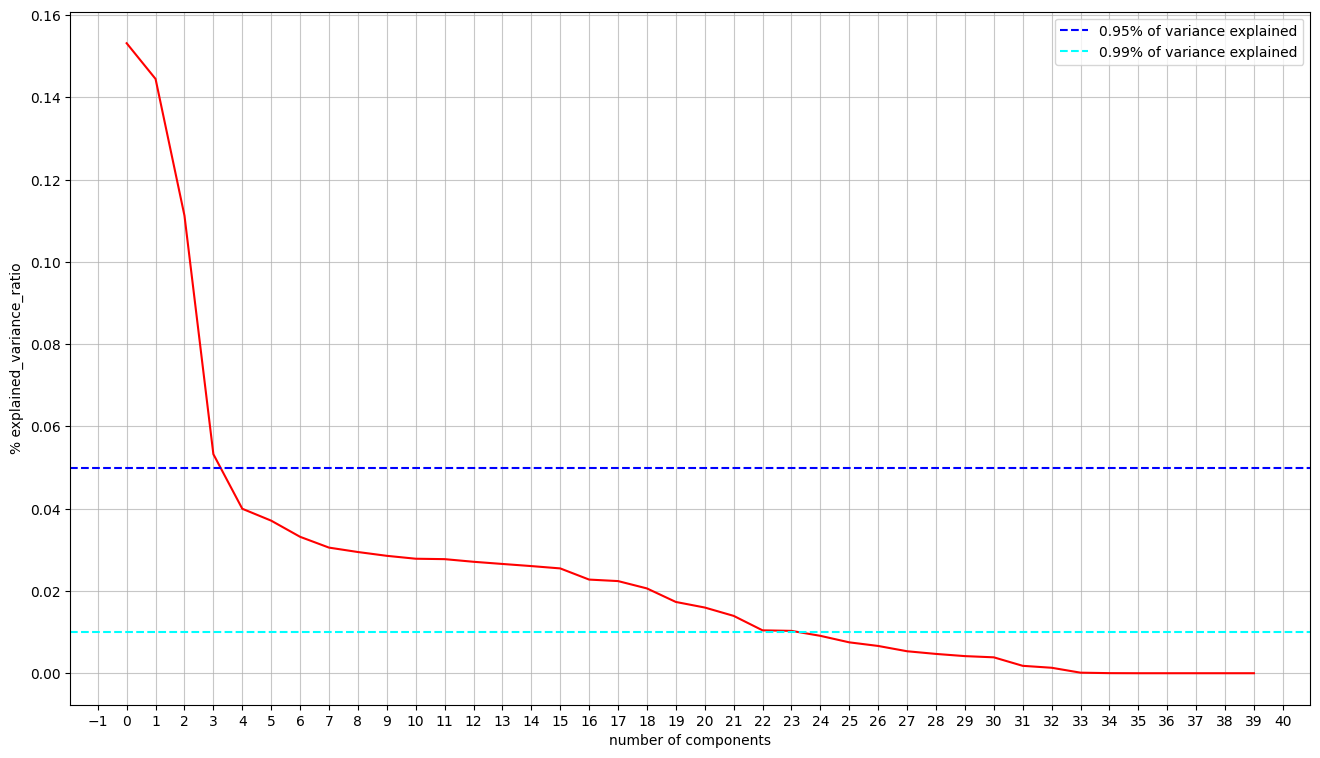

In [15]:
number_comp= Cluster_all_ohe.shape[1]
print(Cluster_all_ohe.shape)
pca= PCA(n_components=number_comp, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

total_variance =sum(pca.explained_variance_)
variance95= total_variance * 0.95
print(f"the total variancein our dataset is {total_variance}")
print(f"the 95% of the variance in our dataset is {variance95}")

a=zip(range(0,number_comp), pca.explained_variance_)
a= pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

plt.figure(1, figsize=(16,9))
plt.plot(pca.explained_variance_ratio_, c="r")
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.axhline(y=0.05, color='blue', linestyle='--', label='0.95% of variance explained')
plt.axhline(y=0.01, color='cyan', linestyle='--', label='0.99% of variance explained')
plt.grid(True, alpha=0.7)
plt.legend()
plt.xlabel("number of components")
plt.ylabel("% explained_variance_ratio")

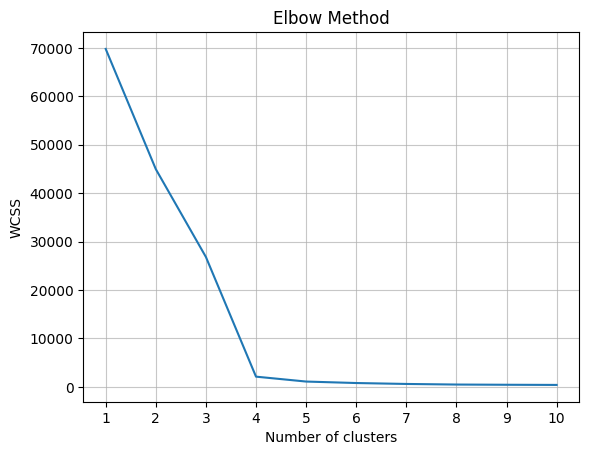

In [16]:
pca= PCA(n_components=3, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

wcss = []  # Within-Cluster-Sum-of-Squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.grid(True, alpha=0.7)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-Cluster-Sum-of-Squares
plt.show()

In [17]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(X_pca)

KMeans(n_clusters=4, random_state=42)

In [18]:
labels = kmeans.labels_

# Calculate the silhouette score for c_raw2
silhouette_score = silhouette_score(X_pca, labels)
print(f"Silhouette Score for 4 clusters: {silhouette_score}")

Silhouette Score for 4 clusters: 0.8848625193210847


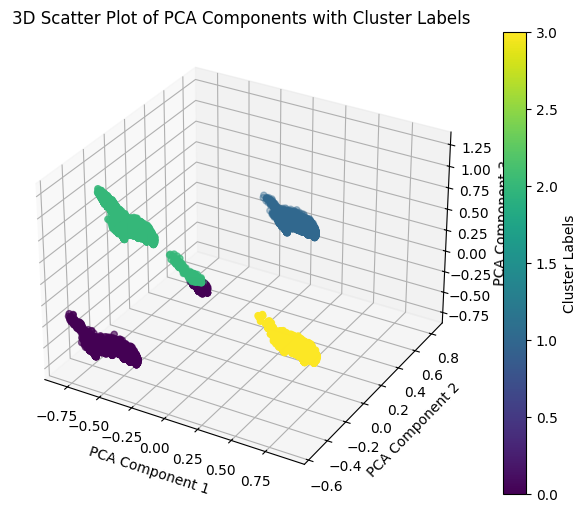

In [19]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded clusters
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')

# Add labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Scatter Plot of PCA Components with Cluster Labels')

# Add colorbar for cluster labels
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster Labels')

# Display the plot
plt.show()

In [20]:
Cluster_all["clusters"]= labels

C:\Users\kevin\AppData\Local\Temp\ipykernel_19732\2568049963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cluster_all["clusters"]= labels


Gaussian Mixture Model

In [21]:
X_pca.shape

(85515, 3)

In [22]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X_pca)
labels = gmm.predict(X_pca)

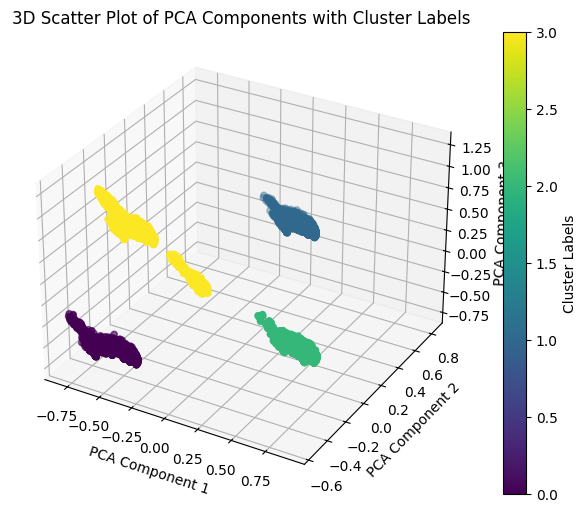

In [23]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded clusters
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')

# Add labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Scatter Plot of PCA Components with Cluster Labels')

# Add colorbar for cluster labels
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster Labels')

# Display the plot
plt.show()

In [24]:
probs = gmm.predict_proba(X_pca)
print(probs[:5].round(3))
print(X_pca)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
[[-0.59172255 -0.3752327   1.01718331]
 [-0.57600892 -0.36924746  1.03750743]
 [-0.60536516 -0.38527874  1.05543503]
 ...
 [-0.13871337 -0.08167215 -0.00792426]
 [-0.16003409 -0.09601774  0.03735422]
 [-0.13229005 -0.07544571 -0.04339323]]


<class 'numpy.ndarray'>
(85515, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85515 entries, 0 to 85514
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   0        85515 non-null  float64
 1   1        85515 non-null  float64
 2   2        85515 non-null  float64
 3   Cluster  85515 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 2.6 MB


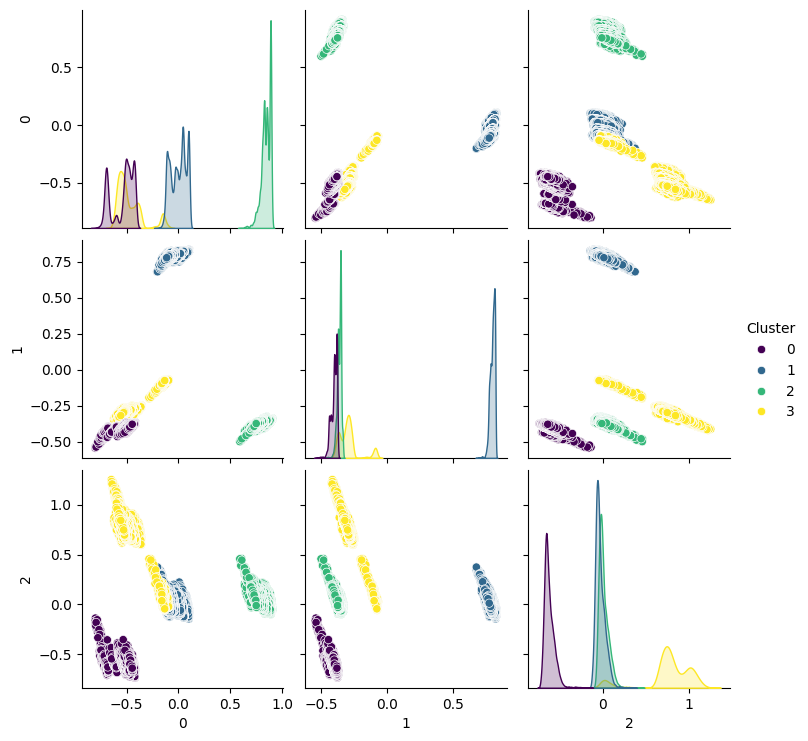

In [25]:
print(type(X_pca))
print(X_pca.shape)
X_pca_df = pd.DataFrame(X_pca)
X_pca_df['Cluster'] = labels
X_pca_df.info()
X_pca_df.describe()
sns.pairplot(X_pca_df, hue='Cluster', palette='viridis')
plt.show()

Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e.,
using Spatial Kernel Density Estimation)

2. Feature Creating & Selection (Nummeric Values)

3. Data Normalisation/Scaling

4. PCA

5. Finding Number of Clusters

6. Clustering (Soft and Hard)

7. Visualisation and Interpretation